In [64]:
from typing import Dict, Any, Callable, List, Optional, Union, Tuple

import re
import subprocess
import tempfile
import pathlib
import dataclasses
import textwrap
import concurrent.futures
import os
import functools
import itertools
import collections
import hashlib
import json
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate

from tqdm import tqdm
import inspect

from IPython.display import display, Markdown

import spot
from spot.jupyter import display_inline
spot.setup(show_default='.bans')

from num2tex import num2tex

import buddy
import graphviz

plt.style.use('seaborn-paper')

In [43]:
def canonicalize_args(f):
    """Wrapper for functools.lru_cache() to canonicalize default                                                          
    and keyword arguments so cache hits are maximized."""

    @functools.wraps(f)
    def wrapper(*args, **kwargs):
        sig = inspect.getfullargspec(f.__wrapped__)

        # build newargs by filling in defaults, args, kwargs                                                            
        newargs = [None] * len(sig.args)
        newargs[-len(sig.defaults):] = sig.defaults
        newargs[:len(args)] = args
        for name, value in kwargs.items():
            newargs[sig.args.index(name)] = value

        return f(*newargs)

    return wrapper

class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)


def persistent_memo(func):
    cache_file = pathlib.Path(f"{func.__name__}.cache.json")
    try:
        with cache_file.open("r") as f:
            memo = json.load(f)
    except FileNotFoundError:
        memo = {}
    @functools.wraps(func)
    def wrapped(*args, **kwargs):
        key = json.dumps((args, kwargs), sort_keys=True, cls=NumpyEncoder)
        key_digest = hashlib.md5(key.encode("utf-8")).hexdigest()
        if key_digest not in memo:
            result = func(*args, **kwargs)
            memo[key_digest] = {"args": args, "kwargs": kwargs, "result": result}
            with cache_file.open("w+") as f:
                json.dump(memo, f, sort_keys=True, cls=NumpyEncoder)
        return memo[key_digest]["result"]
    return wrapped


mungojerrie_path = "mungojerrie/build/mungojerrie"

pattern = re.compile(rf"PAC Probability for tol (\d+(\.\d*)?) is: (?P<satprob>\d+(\.\d*)?)±(?P<std>\d+(\.\d*)?)")

@canonicalize_args
@persistent_memo
def estimate_pac_probability(epsilon: float, 
                             model: str, 
                             min_num_samples: int = 100, 
                             max_est_std: float = 1e-3,
                             reward_type: str = "multi-discount", 
                             discount: float = 0.99999,
                             gammaB: float = 0.99, 
                             learn="Q",
                             lr_schedule: Union[Tuple[str, float], Tuple[str, float, float]] = ("kkt", 10),
                             explore_schedule: Tuple[float, float] = (0.1, 0.1),
                             ep_number: int = 100, 
                             ep_length: int = 10,
                             tolerance=0.,
                             sarsa_lambda: Optional[float] = None,
                             model_params: Dict[str, Any] = None):
    if model_params is None:
        model_params = {}
    
    with tempfile.NamedTemporaryFile(mode='w+') as tmp:
        model_str = pathlib.Path(f"{model}.prism").read_text()
        model_str = model_str.format(**model_params)
        tmp.write(model_str)
        tmp.flush()
        try:
            cmd = [
                    mungojerrie_path, tmp.name, 
                    "--epsilon", "1e-12", # necessary for accurate model checking 
                    "--ltl-file", f"{model}.ltl",
                    "--learn", learn, 
                    "--reward-type", reward_type, 
                    "--discount", str(discount),
                    "--gammaB", str(gammaB),
                    "--tolerance", str(tolerance), 
                    # Learning rates
                    "--alpha", str(lr_schedule[1]) if lr_schedule[0] == "linear" else "0.1",
                    "--linear-lr-decay", str(lr_schedule[2]) if lr_schedule[0] == "linear" else "-1",
                    "--kkt-lr-decay", str(lr_schedule[1]) if lr_schedule[0] == "kkt" else "-1",
                    # Exploration
                    "--explore", str(explore_schedule[0]),
                    "--linear-explore-decay", str(explore_schedule[1]),
                    "--ep-number", str(ep_number),
                    "--ep-length", str(ep_length),
                    # PAC settings
                    "--est-pac",
                    "--est-pac-probability-min-samples", str(min_num_samples),
                    "--est-pac-max-std", str(max_est_std),
                    "--est-pac-epsilon", str(epsilon),
                    "--lambda", str(sarsa_lambda) if sarsa_lambda else "0"
                    # "--seed", str(2),
            ]
#             print(cmd)
            output = subprocess.check_output(
                cmd,
                stderr=subprocess.STDOUT
            )
        except subprocess.CalledProcessError as exc:
            print("Status : FAIL", exc.returncode, exc.output)
            raise exc
    output = output.decode("utf-8")
    match = pattern.search(output)
    pac_prob = float(match.group("satprob"))
    pac_prob_std = float(match.group("std"))
    return pac_prob, pac_prob_std

In [195]:
default_ps = np.geomspace(0.1, 1e-3, num=5)
default_ep_numbers = np.geomspace(1, 10000, num=21, dtype=int)[1:]


def collect_pac_probs(env: str, 
                      ps: List[float] = default_ps, 
                      ep_numbers: List[int] = default_ep_numbers,
                      ep_length: int = 10, 
                      rl_algo: str = "Q", 
                      reward_type: str = "multi-discount", 
                      skip_after_stable: int = float("inf")):
    lr_schedule = {
        "Q": ("kkt", 10),
        "DQ": ("kkt", 30),
        "SL": ("kkt", 10),
    }[rl_algo]

    explore_schedule = {
        "Q": (1.0, 0.1),
        "DQ": (1.0, 0.1),
        "SL": (1.0, 0.001),
    }[rl_algo]

    probs, errs = collections.defaultdict(list), collections.defaultdict(list)
    for p in tqdm(ps):
        err_zero_cnt = 0
        for ep_number in tqdm(ep_numbers, leave=False):
            if err_zero_cnt < skip_after_stable:
                prob, err = estimate_pac_probability(
                    epsilon=0.1, 
                    model=f"models/{env}",
                    model_params=dict(P=p),
                    reward_type=reward_type,
                    max_est_std=1e-2, 
                    discount=0.99999,
                    gammaB=0.99,
                    learn=rl_algo,
                    lr_schedule=lr_schedule,
                    explore_schedule=explore_schedule,
                    ep_number=ep_number, 
                    ep_length=ep_length,
                    sarsa_lambda=0.)
#                 print(p, ep_number, prob, err)
            if prob == 1.0 and err == 0:
                err_zero_cnt += 1
            else:
                err_zero_cnt = 0
            probs[p].append(prob)
            errs[p].append(err)
    
    return probs, errs


def interpolate_and_intersect_pac_delta(probs, errs, delta=0.1, 
                                        ep_numbers: List[int] = default_ep_numbers, 
                                        ep_length: int = 10):
    line, lower, upper = [], [], []
    for p in probs:
        prob = np.array(probs[p])
        err = np.array(errs[p])
        line.append(interpolate.UnivariateSpline(ep_numbers,  prob - (1 - delta), s=0).roots()[0])
        lower.append(interpolate.UnivariateSpline(ep_numbers, prob - err * 2 - (1 - delta), s=0).roots()[0])
        upper.append(interpolate.UnivariateSpline(ep_numbers, prob + err * 2 - (1 - delta), s=0).roots()[0])
    return  (np.array(x) * ep_length for x in (lower, line, upper))


def plot_pac_probs(env: str, probs, errs, 
                   ep_numbers: List[int] = default_ep_numbers,
                   ep_length: int = 10, 
                   rl_algo: str = "Q", 
                   reward_type: str = "multi-discount", 
                   title: Optional[str]=None, delta=0.1, max_intercept_num_samples:Optional[int]=None):    
    if title is None:
        with pathlib.Path(f"models/{env}.prism").open("r") as f:
            lines = f.readlines()
            env_title = env
            for line in lines:
                m = re.match(r"\/\/\s*\@title\s*:\s*(?P<env_title>[^\n]*)\n", line)
                if m:
                    env_title = m.group("env_title")
                    break
    
    sample_numbers = ep_numbers * ep_length
    plt.figure(figsize=(3.5,2.1))
    ps = sorted(probs.keys(), reverse=True)
    lines = []
    linestyles = ['solid', (0, (3, 1, 1, 1, 1, 1)), 'dashdot', 'dashed', 'dotted']
    linestyles_iter = itertools.cycle(linestyles)
    for p in ps:
        prob, err = map(np.array, (probs[p], errs[p]))
        err = np.maximum(err, 1e-3) * 2
        filler = plt.fill_between(sample_numbers, prob-err, prob+err, alpha=0.4)
        eb = plt.errorbar(sample_numbers, prob, yerr=err, linewidth=1, linestyle=next(linestyles_iter))
        lines.append((filler, eb))

    plt.gca().set_xscale("log")
    plt.gca().set_xlabel("#samples")
    plt.gca().set_ylabel("LTL-PAC Prob.")

    plt.axhline(1 - delta, color="#000", alpha=0.4, linestyle="--", linewidth=0.6)
    
    pstex = [f"{p:.0e}".replace("-0","-") for p in ps]
    plt.legend(lines, pstex, title="$p$", handlelength=1.2, loc="lower right")
    rl_algo_to_name = {"Q": "Q-Learning", "DQ": "Double Q-Learning", "SL": "Sarsa($0$)"}
#     reward_type_to_name = {"multi-discount": "Bozkurt"}
    if title is None:
        plt.title(f"{env_title} | {reward_type_to_name.get(reward_type, reward_type)} | {rl_algo_to_name[rl_algo]}")
    elif title != "":
        plt.title(title)
    plt.gcf().tight_layout()
    plt.gcf().savefig(f"plots/{reward_type}-{rl_algo}-{env}", dpi=600)
    plt.show()
    
    # Plot intercept
    lower, line, upper = interpolate_and_intersect_pac_delta(probs, errs, 
                                                             delta=delta, 
                                                             ep_numbers=ep_numbers, 
                                                             ep_length=ep_length)
    plt.figure(figsize=(2.217,2.1))
    plt.errorbar(range(len(ps)), line, yerr=np.array([line-lower, upper-line]), color="#000", alpha=0.4)
    plt.gca().set_xlabel("$p$")
    plt.gca().set_xticks(range(len(ps)))
    plt.gca().set_xticklabels(pstex)
    plt.gca().set_ylabel("#samples")
    if max_intercept_num_samples is not None:
        plt.ylim([0, max_intercept_num_samples])
    plt.gcf().tight_layout()
    if title is None:
        plt.title(f"{env_title} | {reward_type_to_name.get(reward_type, reward_type)} | {rl_algo_to_name[rl_algo]}")
    elif title != "":
        plt.title(title)
    plt.gcf().savefig(f"plots/{reward_type}-{rl_algo}-{env}-intercept-{str(delta).replace('.','_')}", dpi=600)
    plt.show()


  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

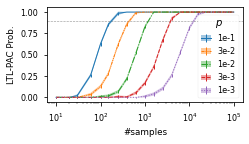

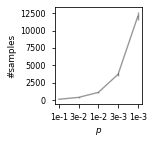

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

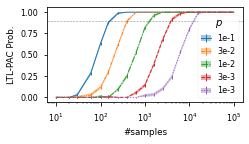

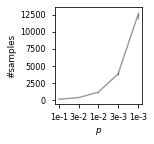

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

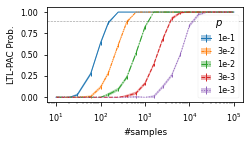

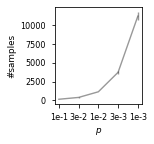

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

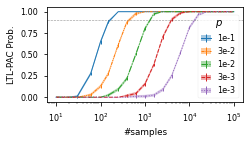

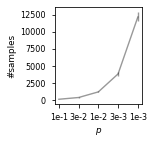

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

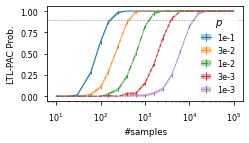

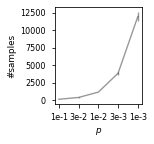

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

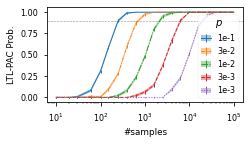

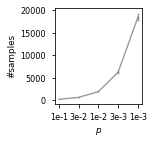

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

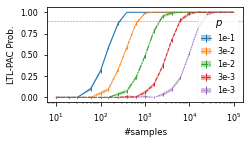

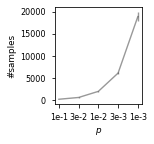

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

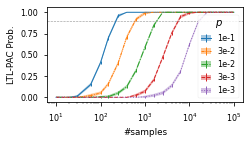

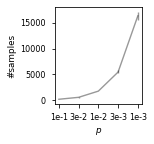

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

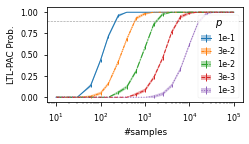

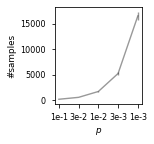

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

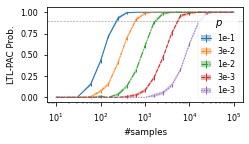

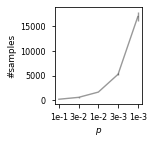

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

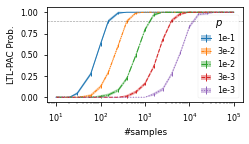

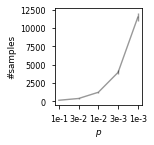

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

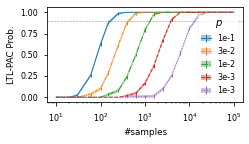

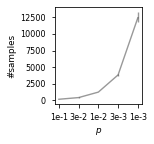

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

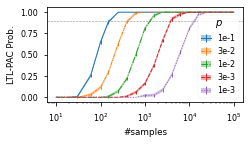

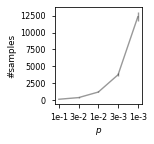

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

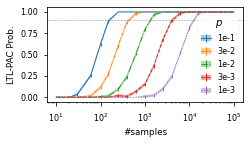

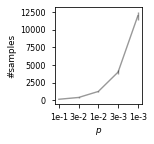

  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                                                
  0%|                                                                                                    | 0/20 [00:00<?, ?it/s]
                                                                                                 

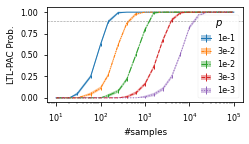

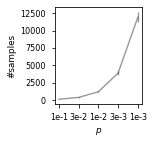

In [196]:
env = "rl_ltl_pac_paper"
reward_types = ["zeta-reach", "zeta-acc", "zeta-discount", "multi-discount", "reward-on-acc"]
rl_algos = ["Q", "DQ", "SL"]
# rl_algos = ["Q"]
for rl_algo, reward_type in itertools.product(rl_algos, reward_types):
    probs, errs = collect_pac_probs(env, rl_algo=rl_algo, reward_type=reward_type, skip_after_stable=3)
    plot_pac_probs(env, probs, errs, rl_algo=rl_algo, reward_type=reward_type, title="")

In [5]:
AP = Tuple[bool]

@dataclasses.dataclass
class TrapChain:
    prefix: AP
    cycle: AP
        
@dataclasses.dataclass
class RegularState:
    label: AP
    trap: TrapChain

@dataclasses.dataclass
class ConstructedMDP:
    aps: Tuple[str]
    top_prefix: List[AP]
    top_cycle: List[AP]
    bottom_prefix: List[AP]
    bottom_cycle: List[AP]
    is_accepting_example: bool = True # Wether this example operates on 
                                      # an accepting or rejecting string


def _collect_formula_aps(formula: spot.formula):
    """Collects the set of atomic propositions in formula."""
    aps = set()
    formula.traverse(lambda f: aps.add(f) if f.kind() == spot.op_ap else None)
    return aps


def _bdd_to_tuple(aps, bdd_dict, bdd):
    """Converts a buddy.bdd to a Python tuple."""
    ret = []
    for ap in aps:
        v = buddy.bdd_ithvar(bdd_dict.varnum(ap))
        ret.append(bool(buddy.bdd_implies(bdd, v))) 
    return tuple(ret)


def _rejecting_run_starting_with(aps: Tuple[str], aut, state):
    """Computes a trap chain by a rejecting run in `aut` starting from `state`.
    
    Args:
        aps: the atomic propositions.
        aut: the automaton to compute the rejecting run on.
        state: the state in `aut` from which the run should start.
    
    Returns:
        a rejecting run.
    """
    current_init_state = aut.get_init_state()
    aut.set_init_state(aut.state_number(state))
    c_aut = spot.complement(aut)
    rej_run = c_aut.accepting_run().reduce()
    aut.set_init_state(aut.state_number(current_init_state))
    assert rej_run is not None, f"Must exists at least one rejecting run from state {state}"
    return rej_run


def to_dra(formula: Union[str, spot.formula]):
    """Converts a LTL formula into a Deterministic Rabin Automaton."""
    if isinstance(formula, str):
        formula = spot.formula(formula)
    aut = formula.translate("deterministic", "complete", "parity", "sbacc")
    aut = spot.to_generalized_rabin(aut, False)
    return aut


def _construct_mdp(formula: Union[str, spot.formula], accepting_example=True):
    """Constructs an counter-example MDP for a particular LTL formula. 
    
    One can show that the constructed MDP has no sample efficient RL algorithm.
    
    Args:
        formula: the LTL formula.
        accepting_example: whether try to create an accepting or rejecting 
          example.

    Returns:
        a ConstructedMDP, or None if the example does not exist.
    """
    if isinstance(formula, str):
        formula = spot.formula(formula)

    if not accepting_example:
      formula = spot.formula_Not(formula)

    # aut = to_dra(formula)
    aut = formula.translate("deterministic", "complete", "parity", "sbacc")
    terminal_aut = spot.decompose_scc(aut, "t")
    if terminal_aut is None:
        # Case pure G
        weakly_accepting_run = aut.accepting_run()
    else:
        weakly_accepting_run = aut.intersecting_run(spot.complement(terminal_aut))
        if weakly_accepting_run is None:
            # Case pure F
            return None
    
    weakly_accepting_run = weakly_accepting_run.reduce()
    aps = tuple(_collect_formula_aps(formula))
    
    rej_run = _rejecting_run_starting_with(aps, aut, weakly_accepting_run.cycle[-1].s)
    bottom_prefix, bottom_cycle = rej_run.prefix, rej_run.cycle
    
    def to_ap(x):
        return _bdd_to_tuple(aps, aut.get_dict(), x.label)
    
    return ConstructedMDP(
        aps=tuple(a.to_str() for a in aps),
        top_prefix=[to_ap(x) for x in weakly_accepting_run.prefix], 
        top_cycle=[to_ap(x) for x in weakly_accepting_run.cycle],
        bottom_prefix=[to_ap(x) for x in bottom_prefix], 
        bottom_cycle=[to_ap(x) for x in bottom_cycle],
        is_accepting_example=accepting_example)


def construct_mdp(formula: Union[str, spot.formula]):
  """Constructs an either accepting or rejecting example MDP.
  
  Args: 
    formula: the LTL formula.
  
  Returns:
    a ConstructedMDP, or None if no example exists (the formula is in B).
  """
  mdp = _construct_mdp(formula, True)
  if mdp is None:
    mdp = _construct_mdp(formula, False)
    if mdp is None:
      assert spot.mp_class(formula) == 'B'
  return mdp    

In [6]:
def to_graphviz(mdp: ConstructedMDP):
    g = graphviz.Digraph('MDP')
    g.attr(rankdir='TB')
    g.attr('node', shape='circle')

    def label_to_str(lab):
        return ",".join([f"{ap}={int(x)}" for ap, x in zip(mdp.aps, lab)])

    def add_action_edge(g, s1, s2, l1="a1, p1", l2="a2, p2", deterministic=False):
        if deterministic:
            g.edge(s1, s2, label="", color="black")
        else:
            g.edge(s1, s2, label=l1, color='blue', fontcolor='blue')
            g.edge(s1, s2, label=l2, color='red', fontcolor='red')

    def add_path(prefix, cycle, name: str, deterministic=False, init=True, color="green"):
        states = list(itertools.chain(prefix, cycle))
        with g.subgraph(name=name) as bg:
            bg.attr(rank="same")
            bg.attr('node', fillcolor=color, style='filled')
            if init:
                bg.node("init", style="invis")
                bg.edge("init", f"{name}-0")
            for s, state in enumerate(states):
                bg.node(f"{name}-{s}", label=label_to_str(state))
            for s1 in range(len(states) - 1):
                s2 = s1 + 1
                l1, l2 = states[s1], states[s2]
                add_action_edge(bg, f"{name}-{s1}", f"{name}-{s2}", deterministic=deterministic)   
            add_action_edge(bg, f"{name}-{len(prefix) + len(cycle) - 1}", f"{name}-{len(prefix)}", deterministic=deterministic)

    add_path(mdp.top_prefix, mdp.top_cycle, name="top_region")
    add_path((mdp.top_prefix + mdp.top_cycle)[1:] + mdp.bottom_prefix, mdp.bottom_cycle, 
             name="bottom_region", deterministic=True, init=False, color="grey")
    
    for s1 in range(len(mdp.top_prefix + mdp.top_cycle)):
        s2 = s1
        add_action_edge(g, f"top_region-{s1}", f"bottom_region-{s2}", l1="a1, 1-p1", l2="a2, 1-a2", 
                        deterministic=False)

    return g


def visualize_constructed_MDP(formula: str):
  """Helper to visualize our construction."""
  mdp = construct_mdp(formula)
  if mdp is None:
    msg = f"""
    The formula `{formula}` is in `B`. 
    It therefore does not have a counter-example MDP.
    """
    msg = textwrap.dedent(msg)
    display(Markdown(msg))
    return

  ar1 = "an **accepting**" if mdp.is_accepting_example else "a **rejecting**"
  ar2 = "an **accepting**" if not mdp.is_accepting_example else "a **rejecting**"
  msg = textwrap.dedent(f"""
  - green: staying in these states creates {ar1} string for the formula ${formula}$
  - grey: entering these states creates {ar2} string for the formula ${formula}$
  - blue transitions taken by action $a_1$
  - red transitions taken by action $a_2$
  """)
  display(to_graphviz(mdp))
  display(Markdown(msg))


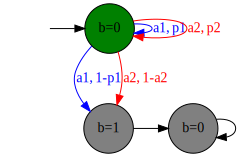


- green: staying in these states creates a **rejecting** string for the formula $F b$
- grey: entering these states creates an **accepting** string for the formula $F b$
- blue transitions taken by action $a_1$
- red transitions taken by action $a_2$


In [11]:
visualize_constructed_MDP("F b")

In [8]:
def rewrite_ltl_formula_for_prism(ltl_formula: str) -> str:
    """Rewrites ltl_formula with proper quoting so it works for prism."""
    ltl = spot.formula(ltl_formula)
    relabel_map = {}
    for ap in spot.atomic_prop_collect(ltl):
        # we add $ here to make spot satisfied with the double quotes...
        # this means that we assumed there are no $ in the AP names
        relabel_map[ap] = spot.formula(f'"${ap}$"')
        relabel_map = spot.relabeling_map(relabel_map)
        ltl_transformed = spot.relabel_apply(ltl, relabel_map)
        # format formula with parenthesis, then remove $
        return f'{ltl_transformed:p}'.replace("$", "")


def to_prism(formula: str, env_title: Optional[str] = None):
    if env_title is None:
        env_title = f"Constructed MDP for {formula}"
    
    mdp = construct_mdp(formula)

    env = f"constructed-mdp-#{formula}#"
    with pathlib.Path(f"models/{env}.prism").open("w+") as f:
        print(textwrap.dedent(f"""
        // @title: {env_title}
        
        mdp
        
        const double p1 = {{P1}};
        const double p2 = {{P2}};
        """)[1:], file=f)
        states = {s: ap for s, ap in enumerate(itertools.chain(mdp.top_prefix, 
                                                               mdp.top_cycle, 
                                                               (mdp.top_prefix + mdp.top_cycle)[1:], 
                                                               mdp.bottom_prefix, 
                                                               mdp.bottom_cycle))
                 }
        
        for i, ap in enumerate(mdp.aps):
            ap_states = "|".join([f"s={s}" for s, sap in states.items() if sap[i]])
            print(f'label "{ap}" = {ap_states};', file=f)
        
        print("", file=f)
        print("module grid", file=f)
        print(f"  s : [0..{len(states)-1}];", file=f)
        print("", file=f)
        
        def print_edge(action, from_state, to_states):
            f.write("[{action}] s={from_state} -> ")
            
        for ai in range(1, 3):
            top_len = len(mdp.top_prefix + mdp.top_cycle)
            for s1 in range(top_len):
                s2 = len(mdp.top_prefix) if s1 == top_len - 1 else s1 + 1 
                s3 = s1 + top_len
                print(f"  [a{ai}] s={s1} -> p{ai} : (s'={s2}) + 1-p{ai} : (s'={s3});", file=f)
            
        for s1 in range(top_len, len(states)):
            s2 = len(states) - len(mdp.bottom_cycle) if s1 == len(states) - 1 else s1 + 1
            print(f"  [] s={s1} -> (s'={s2});", file=f)

        print("endmodule", file=f)
    
    with pathlib.Path(f"models/{env}.ltl").open("w+") as f:
        prism_formula = rewrite_ltl_formula_for_prism(formula)
        print(prism_formula, file=f)
    
    return env

  0%|                                                                                                   | 0/100 [00:00<?, ?it/s]

['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmplilz2s0g', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  1%|▉                                                                                          | 1/100 [00:05<09:46,  5.92s/it]

0.9 1 0.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpupfl463y', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  2%|█▊                                                                                         | 2/100 [00:12<09:49,  6.01s/it]

0.9 3 0.40918 0.00973868
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpqj9dj4j6', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  3%|██▋                                                                                        | 3/100 [00:18<09:53,  6.12s/it]

0.9 5 0.478626 0.00975938
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp9k3sgl6z', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  4%|███▋                                                                                       | 4/100 [00:25<10:19,  6.45s/it]

0.9 10 0.627785 0.00972841
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpuwof_kbx', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  5%|████▌                                                                                      | 5/100 [00:32<10:35,  6.69s/it]

0.9 17 0.716798 0.00969213
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpyaghqmkg', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  6%|█████▍                                                                                     | 6/100 [00:39<10:32,  6.73s/it]

0.9 31 0.864865 0.00963869
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpb78q5jvq', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  7%|██████▎                                                                                    | 7/100 [00:45<10:25,  6.73s/it]

0.9 56 0.98913 0.00764406
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp9gnl0htq', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  8%|███████▎                                                                                   | 8/100 [00:53<10:33,  6.88s/it]

0.9 100 0.994737 0.00524929
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmperxpi74i', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '177', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


  9%|████████▏                                                                                  | 9/100 [01:00<10:43,  7.07s/it]

0.9 177 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpt7q8jco4', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '316', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 10%|█████████                                                                                 | 10/100 [01:08<10:48,  7.20s/it]

0.9 316 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmprdjyz27_', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '562', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 11%|█████████▉                                                                                | 11/100 [01:15<10:50,  7.31s/it]

0.9 562 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp_up02lrw', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 12%|██████████▊                                                                               | 12/100 [01:23<11:08,  7.59s/it]

0.9 1000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp6ch63ins', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1778', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 13%|███████████▋                                                                              | 13/100 [01:32<11:29,  7.93s/it]

0.9 1778 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp3k6dlchi', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3162', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 14%|████████████▌                                                                             | 14/100 [01:41<11:51,  8.27s/it]

0.9 3162 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpbbpyv_2a', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5623', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 15%|█████████████▌                                                                            | 15/100 [01:51<12:33,  8.86s/it]

0.9 5623 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpfw0v6rha', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 16%|██████████████▍                                                                           | 16/100 [02:05<14:15, 10.19s/it]

0.9 10000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpzj15sych', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17782', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 17%|███████████████▎                                                                          | 17/100 [02:24<17:53, 12.93s/it]

0.9 17782 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp8n4u8y4b', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31622', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 18%|████████████████▏                                                                         | 18/100 [02:55<25:00, 18.29s/it]

0.9 31622 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp1vc8izqm', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56234', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 19%|█████████████████                                                                         | 19/100 [03:44<37:22, 27.68s/it]

0.9 56234 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp9dd02al6', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 20%|██████████████████                                                                        | 20/100 [05:08<59:13, 44.41s/it]

0.9 100000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpn8axa1qd', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 21%|██████████████████▉                                                                       | 21/100 [05:14<43:26, 33.00s/it]

0.99 1 0.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpjmh1dpdc', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 22%|███████████████████▊                                                                      | 22/100 [05:21<32:33, 25.04s/it]

0.99 3 0.280094 0.00971831
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpxd13i7i7', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 23%|████████████████████▋                                                                     | 23/100 [05:27<25:01, 19.49s/it]

0.99 5 0.288889 0.00975231
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpbnitarxm', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 24%|█████████████████████▌                                                                    | 24/100 [05:34<19:49, 15.66s/it]

0.99 10 0.370686 0.00973206
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp46c5497w', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 25%|██████████████████████▌                                                                   | 25/100 [05:40<16:12, 12.97s/it]

0.99 17 0.448475 0.00977053
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmproc95g2b', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 26%|███████████████████████▍                                                                  | 26/100 [05:47<13:45, 11.16s/it]

0.99 31 0.53775 0.00978535
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp1vdw1742', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 27%|████████████████████████▎                                                                 | 27/100 [05:55<12:07,  9.97s/it]

0.99 56 0.635236 0.00978916
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpkhfddm33', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 28%|█████████████████████████▏                                                                | 28/100 [06:02<11:05,  9.24s/it]

0.99 100 0.736145 0.00976013
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmprwgeodmx', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '177', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 29%|██████████████████████████                                                                | 29/100 [06:10<10:27,  8.83s/it]

0.99 177 0.827907 0.00972981
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpeh6m0uee', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '316', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 30%|███████████████████████████                                                               | 30/100 [06:17<09:44,  8.35s/it]

0.99 316 0.962264 0.00925425
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp7h20jvur', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '562', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 31%|███████████████████████████▉                                                              | 31/100 [06:25<09:15,  8.05s/it]

0.99 562 0.980695 0.00854973
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp9_o98wbs', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 32%|████████████████████████████▊                                                             | 32/100 [06:32<08:53,  7.84s/it]

0.99 1000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpdsvop8if', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1778', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 33%|█████████████████████████████▋                                                            | 33/100 [06:40<08:52,  7.95s/it]

0.99 1778 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpam5vo2t5', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3162', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 34%|██████████████████████████████▌                                                           | 34/100 [06:49<09:10,  8.35s/it]

0.99 3162 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpmbzi2ju1', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5623', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 35%|███████████████████████████████▍                                                          | 35/100 [07:01<09:57,  9.20s/it]

0.99 5623 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpzadnpyiv', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 36%|████████████████████████████████▍                                                         | 36/100 [07:16<11:38, 10.92s/it]

0.99 10000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpd_c95um6', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17782', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 37%|█████████████████████████████████▎                                                        | 37/100 [07:38<15:07, 14.41s/it]

0.99 17782 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp3mj2dfub', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31622', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 38%|██████████████████████████████████▏                                                       | 38/100 [08:15<21:43, 21.03s/it]

0.99 31622 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpd2kr5y3q', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56234', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 39%|███████████████████████████████████                                                       | 39/100 [09:14<33:12, 32.67s/it]

0.99 56234 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp4xs9ykwu', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 40%|████████████████████████████████████                                                      | 40/100 [10:59<54:19, 54.33s/it]

0.99 100000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpqdscz8o5', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 41%|████████████████████████████████████▉                                                     | 41/100 [11:06<39:19, 39.99s/it]

0.999 1 0.50304 0.00974583
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpsxjwvx91', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 42%|█████████████████████████████████████▊                                                    | 42/100 [11:12<28:57, 29.96s/it]

0.999 3 0.251251 0.00970341
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmppcp7ltyh', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 43%|██████████████████████████████████████▋                                                   | 43/100 [11:19<21:48, 22.96s/it]

0.999 5 0.241273 0.00969399
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpni7m271j', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 44%|███████████████████████████████████████▌                                                  | 44/100 [11:26<16:53, 18.09s/it]

0.999 10 0.270219 0.00968585
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpjq129odx', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 45%|████████████████████████████████████████▌                                                 | 45/100 [11:33<13:28, 14.70s/it]

0.999 17 0.276334 0.0097191
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpt0w5q61n', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 46%|█████████████████████████████████████████▍                                                | 46/100 [11:40<11:09, 12.39s/it]

0.999 31 0.295537 0.00973686
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpmod2igye', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 47%|██████████████████████████████████████████▎                                               | 47/100 [11:47<09:36, 10.88s/it]

0.999 56 0.360083 0.00978826
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp6f7enc9k', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 48%|███████████████████████████████████████████▏                                              | 48/100 [11:55<08:40, 10.02s/it]

0.999 100 0.437081 0.00985178
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpcwev98jn', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '177', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 49%|████████████████████████████████████████████                                              | 49/100 [12:04<08:14,  9.70s/it]

0.999 177 0.494906 0.00989708
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmptw732amb', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '316', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 50%|█████████████████████████████████████████████                                             | 50/100 [12:16<08:37, 10.34s/it]

0.999 316 0.586277 0.00992371
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpq9soycfy', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '562', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 51%|█████████████████████████████████████████████▉                                            | 51/100 [12:32<09:54, 12.14s/it]

0.999 562 0.671111 0.00990445
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpiyi4h5z0', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 52%|██████████████████████████████████████████████▊                                           | 52/100 [12:54<12:02, 15.06s/it]

0.999 1000 0.758877 0.00984735
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmppxefrlma', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1778', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 53%|███████████████████████████████████████████████▋                                          | 53/100 [13:18<13:54, 17.75s/it]

0.999 1778 0.864798 0.0098179
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpp6kd73gw', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3162', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 54%|████████████████████████████████████████████████▌                                         | 54/100 [13:45<15:39, 20.42s/it]

0.999 3162 0.937919 0.00988411
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpxo0rw0xl', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5623', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 55%|█████████████████████████████████████████████████▌                                        | 55/100 [13:56<13:21, 17.82s/it]

0.999 5623 0.99187 0.00809696
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp4fjo_q1x', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 56%|██████████████████████████████████████████████████▍                                       | 56/100 [14:11<12:28, 17.00s/it]

0.999 10000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp6cvpxjsy', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17782', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 57%|███████████████████████████████████████████████████▎                                      | 57/100 [14:34<13:21, 18.64s/it]

0.999 17782 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpwm_heivp', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31622', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 58%|████████████████████████████████████████████████████▏                                     | 58/100 [15:10<16:46, 23.96s/it]

0.999 31622 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp60m9l9py', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56234', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 59%|█████████████████████████████████████████████████████                                     | 59/100 [16:11<23:59, 35.10s/it]

0.999 56234 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpagda5z5x', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 60%|██████████████████████████████████████████████████████                                    | 60/100 [17:56<37:18, 55.97s/it]

0.999 100000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpneznyg04', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 61%|██████████████████████████████████████████████████████▉                                   | 61/100 [18:03<26:44, 41.13s/it]

0.9999 1 0.50304 0.00974583
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmppoddx9_i', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 62%|███████████████████████████████████████████████████████▊                                  | 62/100 [18:09<19:28, 30.76s/it]

0.9999 3 0.487991 0.0097599
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmposzc2uz1', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 63%|████████████████████████████████████████████████████████▋                                 | 63/100 [18:16<14:31, 23.57s/it]

0.9999 5 0.494665 0.0097603
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpsqwh_79h', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 64%|█████████████████████████████████████████████████████████▌                                | 64/100 [18:23<11:06, 18.51s/it]

0.9999 10 0.50344 0.00977554
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp5h0ex0_0', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 65%|██████████████████████████████████████████████████████████▌                               | 65/100 [18:29<08:44, 14.99s/it]

0.9999 17 0.5 0.00977577
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpqe1hdk57', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 66%|███████████████████████████████████████████████████████████▍                              | 66/100 [18:36<07:08, 12.60s/it]

0.9999 31 0.510353 0.00978866
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp39ygjaob', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 67%|████████████████████████████████████████████████████████████▎                             | 67/100 [18:44<06:03, 11.02s/it]

0.9999 56 0.509842 0.00982092
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmprwfwzjcs', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 68%|█████████████████████████████████████████████████████████████▏                            | 68/100 [18:52<05:23, 10.10s/it]

0.9999 100 0.534711 0.00985058
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpn4lj1b5d', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '177', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 69%|██████████████████████████████████████████████████████████████                            | 69/100 [19:01<05:02,  9.76s/it]

0.9999 177 0.585553 0.00989617
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp22dabe71', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '316', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 70%|██████████████████████████████████████████████████████████████▉                           | 70/100 [19:12<05:08, 10.29s/it]

0.9999 316 0.646425 0.0099213
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpswbia63u', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '562', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 71%|███████████████████████████████████████████████████████████████▉                          | 71/100 [19:28<05:42, 11.80s/it]

0.9999 562 0.721896 0.00990576
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpbfn_rv8d', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 72%|████████████████████████████████████████████████████████████████▊                         | 72/100 [19:45<06:14, 13.38s/it]

0.9999 1000 0.84812 0.00984131
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpyfyxpf3t', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1778', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 73%|█████████████████████████████████████████████████████████████████▋                        | 73/100 [19:53<05:24, 12.01s/it]

0.9999 1778 0.985816 0.0099585
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmps9n37xsp', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3162', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 74%|██████████████████████████████████████████████████████████████████▌                       | 74/100 [20:02<04:49, 11.12s/it]

0.9999 3162 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpxkb0yn8q', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5623', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 75%|███████████████████████████████████████████████████████████████████▌                      | 75/100 [20:14<04:39, 11.18s/it]

0.9999 5623 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpgjzxzx2h', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 76%|████████████████████████████████████████████████████████████████████▍                     | 76/100 [20:29<04:57, 12.41s/it]

0.9999 10000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpx04v0au1', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17782', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 77%|█████████████████████████████████████████████████████████████████████▎                    | 77/100 [20:52<05:56, 15.50s/it]

0.9999 17782 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpvflda7j6', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31622', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 78%|██████████████████████████████████████████████████████████████████████▏                   | 78/100 [21:28<07:58, 21.77s/it]

0.9999 31622 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp5ip3oi2k', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56234', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 79%|███████████████████████████████████████████████████████████████████████                   | 79/100 [22:28<11:39, 33.29s/it]

0.9999 56234 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmptjjyn82u', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 80%|████████████████████████████████████████████████████████████████████████                  | 80/100 [24:10<17:55, 53.78s/it]

0.9999 100000 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpo1h_3p6s', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 81%|████████████████████████████████████████████████████████████████████████▉                 | 81/100 [24:16<12:31, 39.58s/it]

0.99999 1 0.495061 0.00974554
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmphbprouop', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 82%|█████████████████████████████████████████████████████████████████████████▊                | 82/100 [24:23<08:53, 29.65s/it]

0.99999 3 0.503811 0.00976058
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpi85hr3x2', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 83%|██████████████████████████████████████████████████████████████████████████▋               | 83/100 [24:29<06:26, 22.72s/it]

0.99999 5 0.499046 0.00976643
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpumat8b15', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 84%|███████████████████████████████████████████████████████████████████████████▌              | 84/100 [24:36<04:46, 17.88s/it]

0.99999 10 0.500382 0.00977577
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmptm3y1fqn', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 85%|████████████████████████████████████████████████████████████████████████████▌             | 85/100 [24:43<03:37, 14.53s/it]

0.99999 17 0.491571 0.00978561
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp39ita2b2', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 86%|█████████████████████████████████████████████████████████████████████████████▍            | 86/100 [24:50<02:51, 12.24s/it]

0.99999 31 0.488077 0.00980302
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp7kq92jj1', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 87%|██████████████████████████████████████████████████████████████████████████████▎           | 87/100 [24:57<02:19, 10.77s/it]

0.99999 56 0.508873 0.00981938
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp4tyw7i2x', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 88%|███████████████████████████████████████████████████████████████████████████████▏          | 88/100 [25:05<01:58,  9.90s/it]

0.99999 100 0.511845 0.00985053
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpkr786yj3', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '177', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 89%|████████████████████████████████████████████████████████████████████████████████          | 89/100 [25:14<01:45,  9.60s/it]

0.99999 177 0.52555 0.00990019
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp7yk9f50j', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '316', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 90%|█████████████████████████████████████████████████████████████████████████████████         | 90/100 [25:26<01:43, 10.36s/it]

0.99999 316 0.496462 0.0099129
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp_sja8ymw', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '562', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 91/100 [25:44<01:54, 12.69s/it]

0.99999 562 0.533544 0.00991031
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpg5npffkj', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 92/100 [26:12<02:19, 17.44s/it]

0.99999 1000 0.549901 0.00992036
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpqen39mtn', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '1778', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 93/100 [26:58<03:00, 25.84s/it]

0.99999 1778 0.595597 0.00990911
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmps0qj32m5', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '3162', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 94/100 [28:12<04:01, 40.18s/it]

0.99999 3162 0.659101 0.00990322
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpu_3qdy4y', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '5623', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [29:52<04:51, 58.32s/it]

0.99999 5623 0.766503 0.00988135
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp00es_rr_', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '10000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [31:43<04:55, 73.97s/it]

0.99999 10000 0.874107 0.00991229
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpfd4gngjs', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '17782', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [33:21<04:04, 81.40s/it]

0.99999 17782 0.94831 0.00987174
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmp1qsf2xie', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '31622', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [33:59<02:16, 68.13s/it]

0.99999 31622 0.990991 0.00896834
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmptu2xw0t9', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '56234', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [34:59<01:05, 65.70s/it]

0.99999 56234 1.0 0.0
['mungojerrie/build/mungojerrie', '/var/folders/8v/xg5xyd3d6fn_k_mh75z9tn3w0000gn/T/tmpfzqo9hkp', '--ltl-file', 'models/constructed-mdp-#G a & F b#.ltl', '--learn', 'Q', '--reward-type', 'multi-discount', '--discount', '0.99999', '--gammaB', '0.99', '--tolerance', '0.0', '--alpha', '0.1', '--linear-lr-decay', '-1', '--kkt-lr-decay', '10', '--explore', '1.0', '--linear-explore-decay', '0.1', '--ep-number', '100000', '--ep-length', '20', '--est-pac', '--est-pac-probability-min-samples', '100', '--est-pac-max-std', '0.01', '--est-pac-epsilon', '0.001', '--lambda', '0']


100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [36:41<00:00, 22.02s/it]

0.99999 100000 1.0 0.0


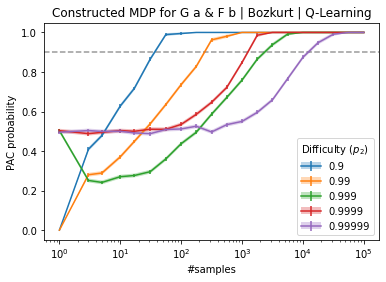

In [9]:
env = to_prism("G a & F b")
probs, errs = collect_pac_probs(env)
plot_pac_probs(env, probs, errs)